In [1]:
# import libraries
install.packages('infotheo')
install.packages('MLmetrics')
install.packages("mltools")
install.packages("randomForest")
library(dplyr)
library(ggplot2)
library(mltools)
library(data.table)
library(infotheo)
library(rpart)
library(randomForest)
library(MLmetrics)
library(gbm)
print('All libraries are loaded')

Installazione pacchetto in 'C:/Users/yuria/Documents/R/win-library/4.1'
(perché 'lib' non è specificato)



package 'infotheo' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'infotheo'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema durante la copia di C:\Users\yuria\Documents\R\win-library\4.1\00LOCK\infotheo\libs\x64\infotheo.dll in C:\Users\yuria\Documents\R\win-library\4.1\infotheo\libs\x64\infotheo.dll: Permission denied"
Warning message:
"restored 'infotheo'"



The downloaded binary packages are in
	C:\Users\yuria\AppData\Local\Temp\RtmpgNiobn\downloaded_packages


Installazione pacchetto in 'C:/Users/yuria/Documents/R/win-library/4.1'
(perché 'lib' non è specificato)



package 'MLmetrics' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yuria\AppData\Local\Temp\RtmpgNiobn\downloaded_packages


Installazione pacchetto in 'C:/Users/yuria/Documents/R/win-library/4.1'
(perché 'lib' non è specificato)



package 'mltools' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yuria\AppData\Local\Temp\RtmpgNiobn\downloaded_packages


Installazione pacchetto in 'C:/Users/yuria/Documents/R/win-library/4.1'
(perché 'lib' non è specificato)



package 'randomForest' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'randomForest'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema durante la copia di C:\Users\yuria\Documents\R\win-library\4.1\00LOCK\randomForest\libs\x64\randomForest.dll in C:\Users\yuria\Documents\R\win-library\4.1\randomForest\libs\x64\randomForest.dll: Permission denied"
Warning message:
"restored 'randomForest'"



The downloaded binary packages are in
	C:\Users\yuria\AppData\Local\Temp\RtmpgNiobn\downloaded_packages


Warning message:
"il pacchetto 'dplyr' è stato creato con R versione 4.1.3"

Caricamento pacchetto: 'dplyr'


I seguenti oggetti sono mascherati da 'package:stats':

    filter, lag


I seguenti oggetti sono mascherati da 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"il pacchetto 'ggplot2' è stato creato con R versione 4.3.0"
Warning message:
"il pacchetto 'mltools' è stato creato con R versione 4.1.3"
Warning message:
"il pacchetto 'data.table' è stato creato con R versione 4.1.3"

Caricamento pacchetto: 'data.table'


I seguenti oggetti sono mascherati da 'package:dplyr':

    between, first, last


Warning message:
"il pacchetto 'infotheo' è stato creato con R versione 4.1.3"
Warning message:
"il pacchetto 'randomForest' è stato creato con R versione 4.1.3"
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Caricamento pacchetto: 'randomForest'


Il seguente oggetto è mascherato da 'package:ggplot2':

    margin


Il seguente 

[1] "All libraries are loaded"


# Richter's Predictor: Modeling Earthquake Damage
Modeling how different variables affect the odds of different damage outcomes to buildings after the 2015 Gorkha earthquake in Nepal

by: <u>Jean-Christophe Gaudreau</u> and <u>Yuri Antonelli</u>

In [2]:
# Import data
trainset=read.csv("train_labels.csv")
trainvalues=read.csv("train_values.csv")
testset=read.csv("test_values.csv")
subset=read.csv("submission_format.csv")

Here are the different functions that will be utilized for testing the our predictions

In [3]:
ConfusionMatrix <- function(y_pred, y_true) {
  Confusion_Mat <- table(y_true, y_pred)
  return(Confusion_Mat)
}
 
ConfusionDF <- function(y_pred, y_true) {
  Confusion_DF <- transform(as.data.frame(ConfusionMatrix(y_pred, y_true)),
                            y_true = as.character(y_true),
                            y_pred = as.character(y_pred),
                            Freq = as.integer(Freq))
  return(Confusion_DF)
}
 
Precision_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  # this is not bulletproof since there might be labels missing (in strange cases)
  # in strange cases where they existed in training set but are missing from test ground truth and predictions.
 
  TP <- c()
  FP <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]
   
    # it may happen that a label is never predicted (missing from y_pred) but exists in y_true
    # in this case ConfusionDF will not have these lines and thus the simplified code crashes
    # TP[i] <- as.integer(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"])
    # FP[i] <- as.integer(sum(Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]))
   
    # workaround:
    # i don't want to change ConfusionDF since i don't know if the current behaviour is a feature or a bug.
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
   
    tmp <- Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]
    FP[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Precision_micro <- sum(TP) / (sum(TP) + sum(FP))
  return(Precision_micro)
}
 
Recall_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  # this is not bulletproof since there might be labels missing (in strange cases)
  # in strange cases where they existed in training set but are missing from test ground truth and predictions.
 
  TP <- c()
  FN <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]
   
    # short version, comment out due to bug or feature of Confusion_DF
    # TP[i] <- as.integer(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"])
    # FP[i] <- as.integer(sum(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]))
   
    # workaround:
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
 
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]
    FN[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Recall_micro <- sum(TP) / (sum(TP) + sum(FN))
  return(Recall_micro)
}
 
F1_Score_micro <- function(y_true, y_pred, labels = NULL) {
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred)) # possible problems if labels are missing from y_*
  Precision <- Precision_micro(y_true, y_pred, labels)
  Recall <- Recall_micro(y_true, y_pred, labels)
  F1_Score_micro <- 2 * (Precision * Recall) / (Precision + Recall)
  return(F1_Score_micro)
}

## 1. Data preprocessing
Lets first implement a preprocessing pipeline to remove unnecessary data and filter categorical data

### 1.1 Exploratory Data Analysis

In [4]:
head(trainset)
dim(trainset)

,building_id,damage_grade
,<int>,<int>
1,802906,3
2,28830,2
3,94947,3
4,590882,2
5,201944,3
6,333020,2


[1] 260601      2

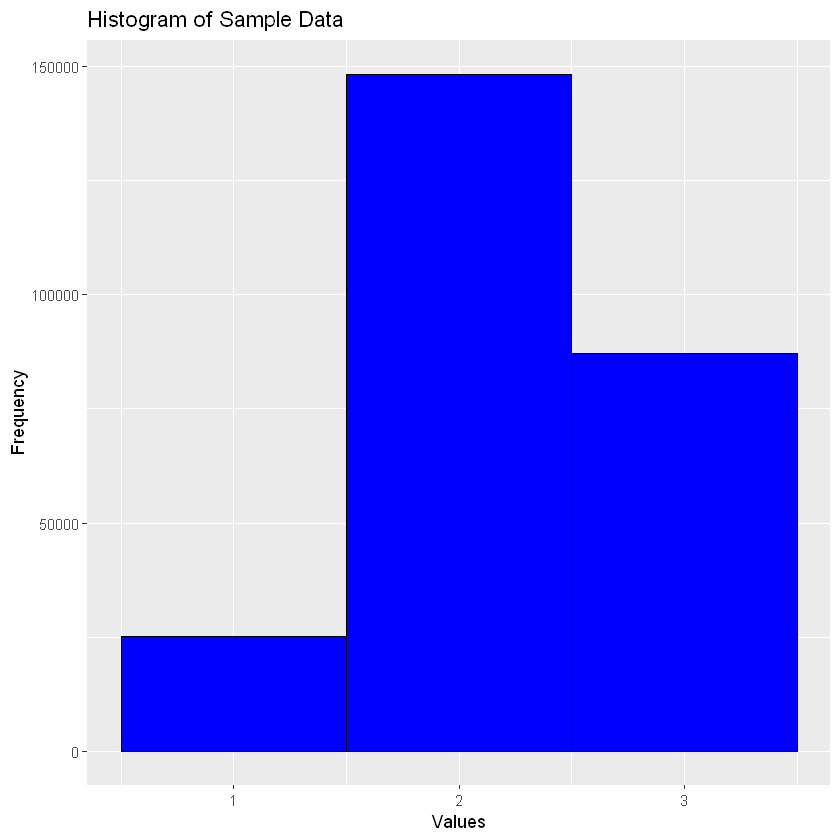

In [5]:
#Let's plot the histogramme of the target variable- damage_grade
ggplot(trainset, aes(x = damage_grade)) + 
  geom_histogram(binwidth = 1, fill = "blue", color = "black") + 
  ggtitle("Histogram of Sample Data") + 
  xlab("Values") + 
  ylab("Frequency")

First thing we can notice is the unbalancedness of our target variable, which can affect tremendously the efficiency of our algorithms.

In [6]:
head(trainvalues)
dim(trainvalues)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
2,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
3,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
5,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0
6,333020,8,558,6089,2,10,9,5,t,r,...,1,0,0,0,0,0,0,0,0,0


[1] 260601     39

In [7]:
head(testset)
dim(testset)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,300051,17,596,11307,3,20,7,6,t,r,...,0,0,0,0,0,0,0,0,0,0
2,99355,6,141,11987,2,25,13,5,t,r,...,1,0,0,0,0,0,0,0,0,0
3,890251,22,19,10044,2,5,4,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,745817,26,39,633,1,0,19,3,t,r,...,0,0,1,0,0,0,0,0,0,0
5,421793,17,289,7970,3,15,8,7,t,r,...,0,0,0,0,0,0,0,0,0,0
6,871976,22,170,4029,1,55,4,3,t,r,...,0,0,0,0,0,0,0,0,0,0


[1] 86868    39

In [8]:
head(subset)
dim(subset)

,building_id,damage_grade
,<int>,<int>
1,300051,1
2,99355,1
3,890251,1
4,745817,1
5,421793,1
6,871976,1


[1] 86868     2

### 1.2 Transforming categorical data into binary encoding (One-Hot)
+Matching training feature and training target datasets, by "building_id"

In [9]:
# Matching Label data ton Values data to have as many datapoints for both CSVs
master <- left_join(y=trainset,x=trainvalues,by="building_id",all.x=TRUE)
# Check the number of NA's
sum(is.na(master))

[1] 0

Here, we have a list of all available categorical data. Although geo_level IDs are integers, they are also considered as categorical since each IDs represents a different house, and there is no visible linear behavior between each ID. Therefore, we can encode <u>**geo_level_1_id**</u> with One-hot without encountering difficulties with the dimensions of our dataset ($\approx$ 30 columns). We decided to leave out <u>**geo_level_id 2-3**</u> due to this complexity problem (for now...).

One-hot encoding is not really an option in this situation since geo_levels_3_id, which range from 0 to 12567, could induce high-dimensionality and sparse data with one-hot, therefore requiring more and more preprocessing.

In [10]:
## one-hot encode test and train sets

cat_cols=c('land_surface_condition', 'foundation_type',"roof_type","ground_floor_type",
"other_floor_type","position","plan_configuration","legal_ownership_status","geo_level_1_id")

# use dummyVars function to create binary encoding for categorical variables
master_encoded = master
# Loop through the categorical columns and encode each column
for (col in cat_cols) {
  dict <- unique(master[[col]])
  binary_matrix <- matrix(0L, nrow = nrow(master), ncol = length(dict))
  for (i in 1:length(dict)) {
    binary_matrix[master[[col]] == dict[i], i] <- 1L
  }
  colnames(binary_matrix) <- paste0(col, "_", dict)
  master_encoded <- cbind(master_encoded, binary_matrix)
}

for (col in cat_cols) {
  dict <- unique(testset[[col]])
  binary_matrix <- matrix(0L, nrow = nrow(testset), ncol = length(dict))
  for (i in 1:length(dict)) {
    binary_matrix[testset[[col]] == dict[i], i] <- 1L
  }
  colnames(binary_matrix) <- paste0(col, "_", dict)
  testset <- cbind(testset, binary_matrix)
}

# Remove the original categorical columns from the new dataframe
master_encoded <- master_encoded[, !colnames(master_encoded) %in% cat_cols]
testset = testset[, !colnames(testset) %in% cat_cols]

#see result
head(master_encoded)
head(testset)


,building_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,geo_level_1_id_5,geo_level_1_id_15,geo_level_1_id_14,geo_level_1_id_19,geo_level_1_id_1,geo_level_1_id_24,geo_level_1_id_28,geo_level_1_id_23,geo_level_1_id_2,geo_level_1_id_29
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,802906,487,12198,2,30,6,5,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,28830,900,2812,2,10,8,7,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,94947,363,8973,2,10,5,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,590882,418,10694,2,10,6,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,201944,131,1488,3,30,8,9,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,333020,558,6089,2,10,9,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0


,building_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,geo_level_1_id_5,geo_level_1_id_19,geo_level_1_id_15,geo_level_1_id_14,geo_level_1_id_29,geo_level_1_id_9,geo_level_1_id_2,geo_level_1_id_28,geo_level_1_id_24,geo_level_1_id_23
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,300051,596,11307,3,20,7,6,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,99355,141,11987,2,25,13,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,890251,19,10044,2,5,4,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,745817,39,633,1,0,19,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,421793,289,7970,3,15,8,7,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,871976,170,4029,1,55,4,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<strong>GEO_LEVEL VARIABLES</strong> [THIS HAS TO BE INSERTED BEFORE ONE-HOT-ENCODING]

Let's do a scatter plot using 1 and 2 with different color for the target variable output, in order to see if any pattern in data can be used for feature engineering

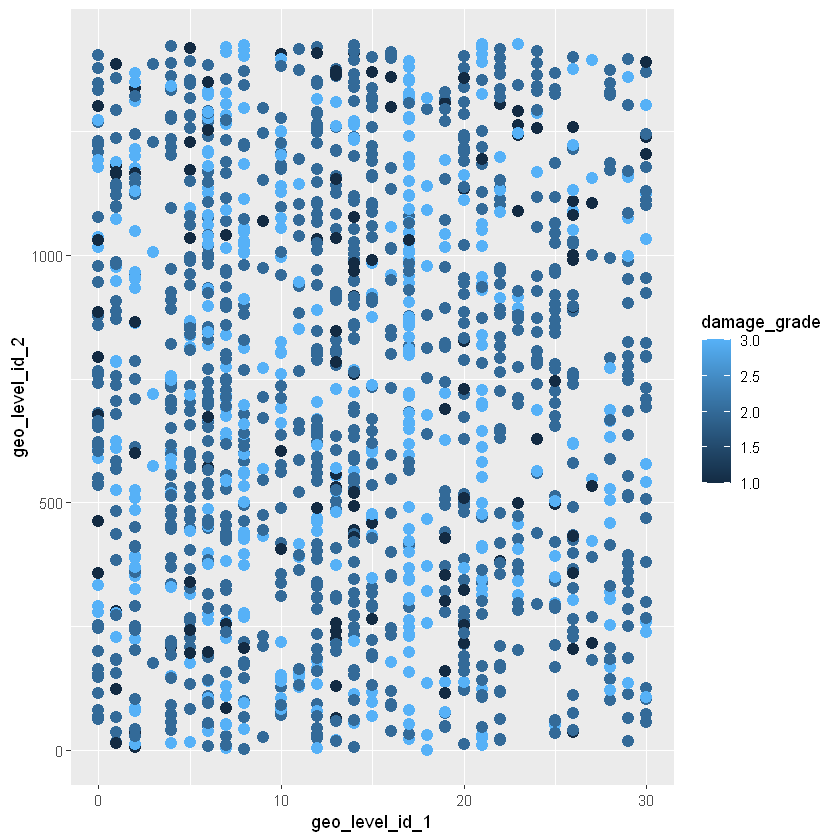

In [11]:
ggplot(data = master, aes(x = geo_level_1_id, y = geo_level_2_id, color = damage_grade)) +
  geom_point(size = 3) +
  labs(x = "geo_level_id_1", y = "geo_level_id_2", color = "damage_grade")

It seems that no clear pattern can be exploited to do feature engineering, therefore let's procede by one-hot-encoding geo_level_id_1 which is the only one with a reasonable number of unique values, the other two variables would increase the features space size too much

### Feature Selection
Our dataset is characterized by a large number of variables, therefore we need a way to select the most relevant for our problem.
We use a ranking algorithm based on the mutual information criterium.

In [12]:
# delete useless columns for the Mutual Information Ranking
df_train = copy(master_encoded)
df_train$building_id = NULL
df_train$damage_grade = NULL
df_train$geo_level_2_id = NULL
df_train$geo_level_3_id = NULL

# dataframe to store the results
mi_df = data.frame(matrix(nrow = length(colnames(df_train)), ncol = 1))
rownames(mi_df) = colnames(df_train)
colnames(mi_df) = 'Mutual_Information'

for (i in 1:length(df_train)){
    a = mutinformation(df_train[ ,i], master_encoded$damage_grade)
    mi_df[i, 1] = a
    mi_df <- arrange(mi_df, desc(Mutual_Information))
    
}

# results
head(mi_df)

,Mutual_Information
,<dbl>
foundation_type_r,0.06294687
ground_floor_type_v,0.05233678
has_superstructure_mud_mortar_stone,0.04921463
geo_level_1_id_17,0.04396153
roof_type_x,0.03997262
foundation_type_i,0.03549682


## 2. Model Selection
In this section we are going to train different models taking into account different sets of features, with the aim to select the best options to tackle our problem. In particular, considering the ranking previously created, we are going to add one feature each time and which model perform the best.

The 3 models that we are going to use, from the simplest to the most complex, are:
1. decision tree
2. random forest
3. neural network

Given the huge dimension of the dataset, we are going to assess the quality of the models by means of a classic train-validation split, since cross-validation would be computationally too expensive.

In [13]:
# Train-Test split
train_prop = 0.02 # around 5000 observations

# calculate the number of rows to use for training
train_size <- round(nrow(master_encoded) * train_prop)

# Shuffle the rows of the dataset
set.seed(123)
data_shuffled <- master_encoded[sample(nrow(master_encoded)),]

# Split the shuffled data into training and test sets
train_data <- data_shuffled[1:train_size,]
test_data <- data_shuffled[(train_size+1):nrow(data_shuffled),]

# results
head(train_data)
dim(train_data)
head(test_data)
dim(test_data)



,building_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,geo_level_1_id_5,geo_level_1_id_15,geo_level_1_id_14,geo_level_1_id_19,geo_level_1_id_1,geo_level_1_id_24,geo_level_1_id_28,geo_level_1_id_23,geo_level_1_id_2,geo_level_1_id_29
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
182735,23555,749,11087,2,10,12,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
188942,848406,996,7719,3,50,7,6,0,1,0,...,0,0,0,0,0,0,0,0,0,0
134058,562045,1411,12035,2,10,22,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124022,491150,349,5322,2,80,9,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
160997,12219,463,4692,2,20,10,4,0,1,0,...,0,0,0,0,0,0,0,0,0,0
226318,880155,1050,11785,2,0,6,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[1] 5212  100

,building_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,geo_level_1_id_5,geo_level_1_id_15,geo_level_1_id_14,geo_level_1_id_19,geo_level_1_id_1,geo_level_1_id_24,geo_level_1_id_28,geo_level_1_id_23,geo_level_1_id_2,geo_level_1_id_29
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
255637,298261,852,5192,2,15,13,7,1,1,0,...,0,0,0,0,0,0,0,0,0,0
151058,476649,30,7205,2,15,9,4,0,1,0,...,0,0,0,0,0,0,0,0,0,0
51928,550727,788,9253,2,5,6,4,0,1,0,...,0,0,0,0,0,0,0,0,0,0
96987,75193,765,3808,4,30,14,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
256453,848527,1121,2723,3,0,8,8,0,1,0,...,0,0,0,0,0,0,0,0,0,0
19476,797425,390,600,4,90,16,10,1,0,0,...,0,0,0,0,0,0,0,0,0,0


[1] 255389    100

In [14]:
# weigth to deal with unbalancedness in the random forest algorithm
class_frequencies <- table(trainset$damage_grade)
class_weights <- 1 / class_frequencies
classwt <- class_weights / sum(class_weights)
classwt


        1         2         3 
0.6860969 0.1162661 0.1976369 

<strong>CORE TRAINING AND TESTING FUNCTION</strong>

In [25]:
feature_sel = function(max_n, model){
    max_n_features = max_n
    my_index <- which(colnames(train_data) == "damage_grade")
    names = rownames(mi_df)

    # create the dataframe
    indexes_features = c()
    performance_df = data.frame(matrix(nrow = max_n_features, ncol = 2))
    colnames(performance_df) = c('train_perf', 'test_perf')
    rownames(performance_df) = 1:max_n_features

    for (i in 1:max_n_features){
        n = which(colnames(train_data) == names[i])
        indexes_features[i] = n
        train = train_data[ ,indexes_features]
        test = test_data[ ,indexes_features]
        train$damage_grade = as.factor(as.character(train_data$damage_grade))
        test$damage_grade = as.factor(as.character(test_data$damage_grade))
        
        if (i >= 2){
            if (model == 'dec_tree'){
                # Train a decision tree model on the training data
                tree_model <- rpart(damage_grade ~ ., data = train)

                # Predict the labels for the training and test sets
                train_pred <- predict(tree_model, train, type = "class")
                test_pred <- predict(tree_model, test_data, type = "class")

                # Calculate the accuracy of the model on the training and test sets
                train_acc <- F1_Score_micro(train$damage_grade, train_pred)
                test_acc <- F1_Score_micro(test$damage_grade, test_pred)

                # store the results
                performance_df[i, 1] = train_acc
                performance_df[i, 2] = test_acc 
            }
            if (model == 'rand_for'){
                # Train a decision tree model on the training data
                rf_model <- randomForest(damage_grade ~ ., data = train, ntree = 100, classwt=classwt)

                # Predict the labels for the training and test sets
                train_pred <- predict(rf_model, newdata = train[ ,1:i])
                test_pred <- predict(rf_model, newdata = test)

                # Calculate the accuracy of the model on the training and test sets
                train_acc = F1_Score_micro(train$damage_grade, train_pred)
                test_acc = F1_Score_micro(test$damage_grade, test_pred)

                # store the results
                performance_df[i, 1] = train_acc
                performance_df[i, 2] = test_acc 
            }
            if (model == 'grad_boosting'){
                # Train gradient boosting gradient boosting
                gbm_model <- gbm(damage_grade ~ ., data = train, distribution = "multinomial", n.trees = 100, interaction.depth = 3, shrinkage = 0.1)

                # Accuracy 
                pred1 = predict.gbm(object = gbm_model,
                                newdata = train,
                                n.trees = 100,           
                                type = "response")

                pred2 = predict.gbm(object = gbm_model,
                                newdata = test,
                                n.trees = 100,           
                                type = "response")

                labels1 = colnames(pred1)[apply(pred1, 1, which.max)]
                labels2 = colnames(pred2)[apply(pred2, 1, which.max)]

                result1 = data.frame(train_data$building_id, labels1)
                result2 = data.frame(test_data$building_id, labels2)

                train_acc <- F1_Score_micro(train$damage_grade, result1$labels1)
                test_acc <- F1_Score_micro(test$damage_grade, result2$labels2)

                # store the results
                performance_df[i, 1] = train_acc
                performance_df[i, 2] = test_acc 
            }
        }
    }
    head(performance_df)
    plot(performance_df$train_perf, type='l', col=1)
    lines(rownames(performance_df), performance_df$test_perf, col="#e40b0b",lty=2)
}

### 2.1 Decision Tree

Warning message in train$damage_grade <- as.factor(as.character(train_data$damage_grade)):
"Trasformo il membro di sinistra in una lista"
Warning message in test$damage_grade <- as.factor(as.character(test_data$damage_grade)):
"Trasformo il membro di sinistra in una lista"


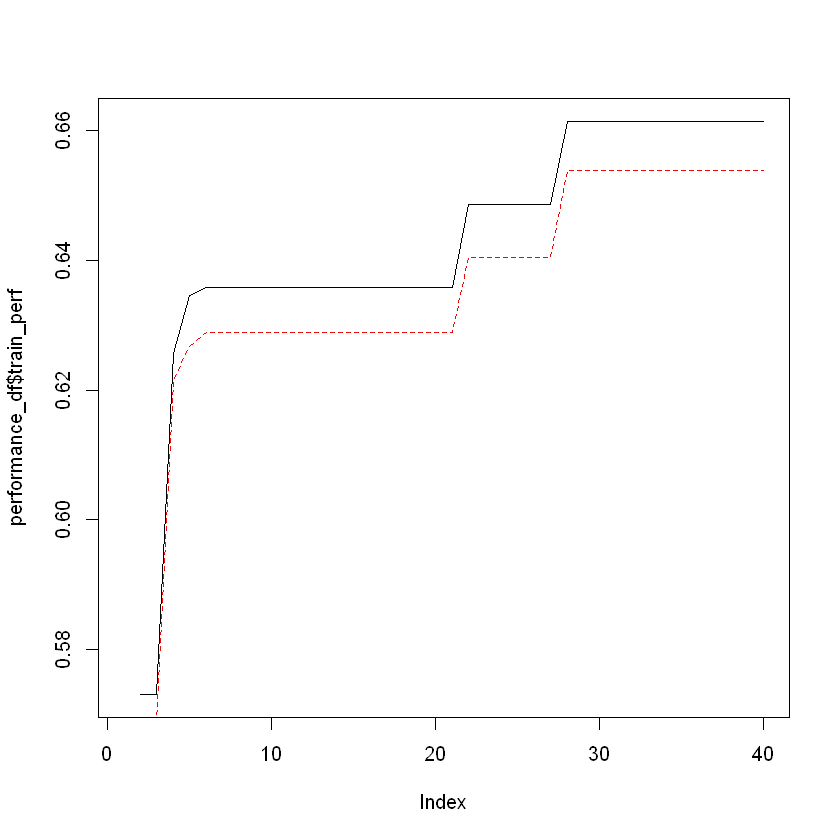

In [24]:
feature_sel(40, 'dec_tree')

### 2.2 Random Forest

Warning message in train$damage_grade <- as.factor(as.character(train_data$damage_grade)):
"Trasformo il membro di sinistra in una lista"
Warning message in test$damage_grade <- as.factor(as.character(test_data$damage_grade)):
"Trasformo il membro di sinistra in una lista"


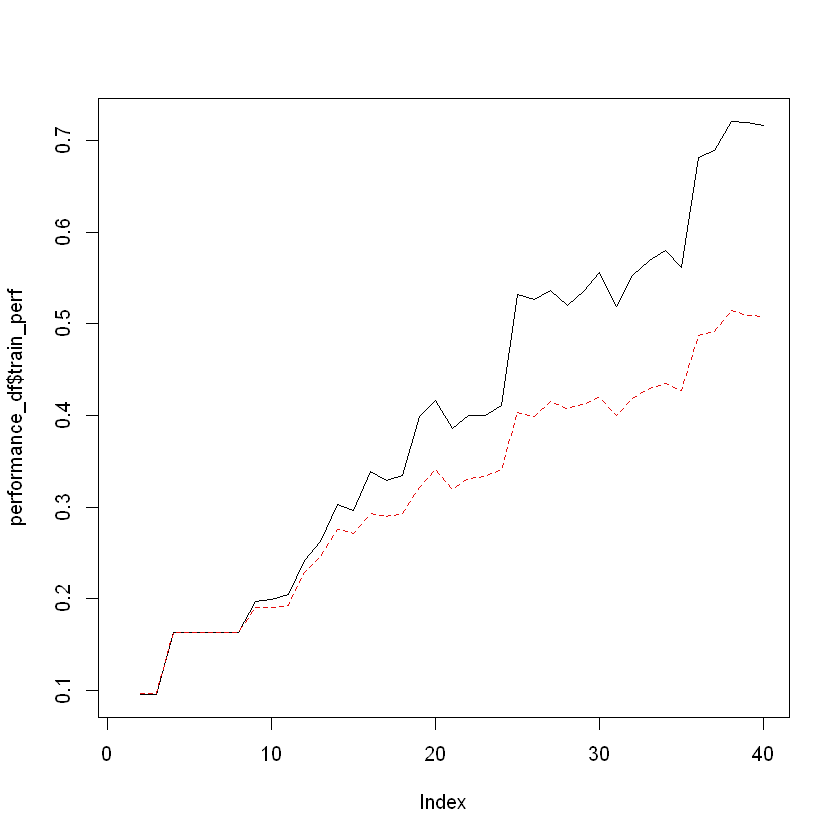

In [26]:
feature_sel(40, 'rand_for')

### 2.3 Neural Network 


## 3. Extra Learning Procedure: Gradient Boosting

Warning message in train$damage_grade <- as.factor(as.character(train_data$damage_grade)):
"Trasformo il membro di sinistra in una lista"
Warning message in test$damage_grade <- as.factor(as.character(test_data$damage_grade)):
"Trasformo il membro di sinistra in una lista"
Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."
Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."
Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."
Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."
Warning message:
"Setting `distribution = "multinomial"` is il

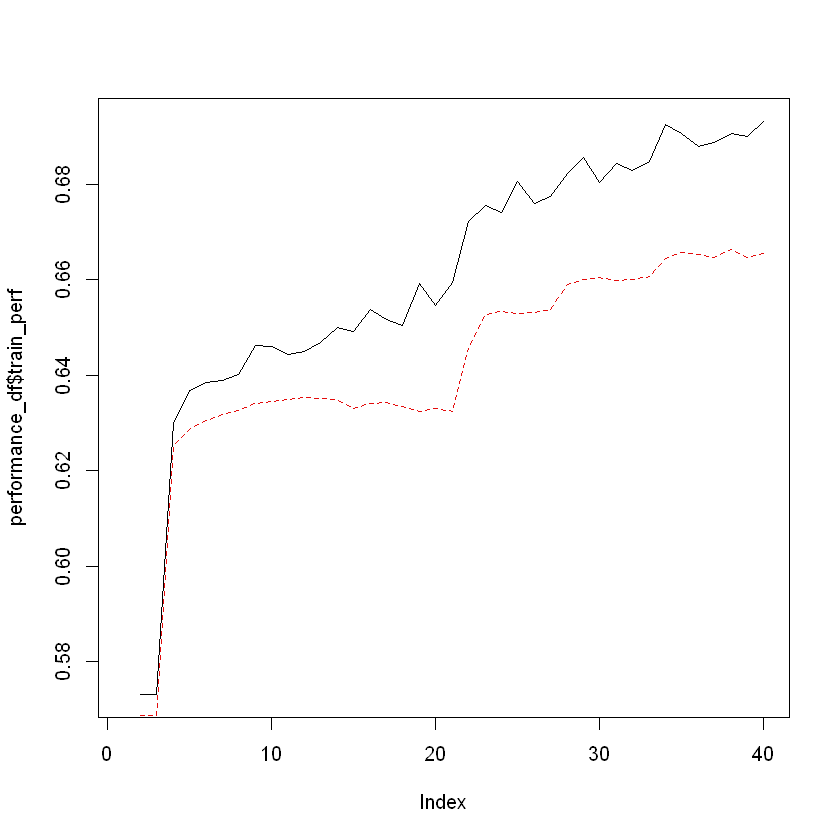

In [21]:
feature_sel(40, 'grad_boosting')

## 4. Feature Relevance

In [56]:
entropy = function(df){
    # create the table of predictions with percentages
    y = as.data.frame(table(df))
    y$Freq = y$Freq / sum(y$Freq)

    # add a column for computing P(y)*log(P(y))
    y$ent = y$Freq*log(y$Freq)
    y[is.na(y)] <- 0

    # entropy
    ent = -sum(y$ent)
    ent
}

index_ranking = function(train_data, test_data, n_features){
    # create a dataframe for the ranking
    ranking = data.frame(matrix(nrow = n_features, ncol = 1))
    rownames(ranking) = rownames(mi_df)[1:n_features]
    colnames(ranking) = 'Index'

    # let's store the variable we use in a dataframe
    df1 = train_data[rownames(mi_df)[1:n_features]]
    damage_grade = as.factor(as.character(train_data$damage_grade))
    df2 = test_data[rownames(mi_df)[1:n_features]]

    # train a full model
    random_for <- randomForest(damage_grade ~ ., data = df1, classwt = classwt, ntree=200)
    test_pred <- predict(random_for, df2, type='class') 
    entr_full = entropy(test_pred)

    for (i in 1:ncol(df1)){
        # remove the i-th feature
        random_for2 <- randomForest(damage_grade ~ ., data = df1[, -i], classwt = classwt, ntree=200)
        # Predict the labels for the test set
        test_pred2 <- predict(random_for, df2, type='class') 
        # compute the entropy without the i-th 
        entr_not_full = entropy(test_pred2)
        # index value
        ind = entr_not_full - entr_full
        # add in the ranking
        feature = rownames(mi_df)[i]
        ranking[i, 1] = ind
    }
    # see result
    ranking
    sorted_ranking <- arrange(ranking, desc(Index))
    sorted_ranking

}

index_ranking(train_data, test_data, 10)


,Index
,<dbl>
ground_floor_type_f,1.259569e-04
ground_floor_type_v,7.593709e-05
has_superstructure_cement_mortar_brick,5.003892e-05
geo_level_1_id_17,4.258418e-05
foundation_type_r,2.590580e-05
roof_type_x,-9.227524e-06
foundation_type_i,-1.668220e-05
has_superstructure_mud_mortar_stone,-2.591099e-05
age,-4.082052e-05


## 5. Submission

In [35]:
# let's store the variable we use in a dataframe
#df1 = train_data[rownames(mi_df)[1:50]] 
#damage_grade = as.factor(as.character(train_data$damage_grade))
#df2 = testset[rownames(mi_df)[1:50]]
#damage_grade1 = train_data$damage_grade

# Train gradient boosting gradient boosting
#gbm_model <- gbm(damage_grade1 ~ ., data = df1, distribution = "multinomial", n.trees = 100, interaction.depth = 3, shrinkage = 0.1)

# Prediction 
#pred = predict.gbm(object = gbm_model,
                #newdata = df2,
                #n.trees = 100,           
                #type = "response")



In [34]:
#labels = colnames(pred2)[apply(pred, 1, which.max)]
#test_pred = as.data.frame(labels)

# submission formatting
#submission = data.frame(testset$building_id, test_pred)
#colnames(submission) = c('building_id', 'damage_grade')
#head(submission)
#dim(submission)

# save csv
#file_path <- "C:/Users/yuria/Desktop/submission.csv"
#write.csv(submission, file=file_path, row.names = FALSE)